Human detector
---

Это тестовое задание для компании BND LLC на должность Data Scientist (Junior). 

Дан видеофайл crowd.mp4. Мне необходимо написать программу на языке Python, которая будет выполнять детекцию людей и их отрисовку на этом видео. Также нужно проанализировать полученный результат и сформулировать шаги по дальнейшему улучшению качества распознавания.

Вначале загрузим необходимые библиотеки

In [ ]:
from pathlib import Path

import torch
import torchvision
import torchvision.transforms.v2 as v2
from torchvision.ops import nms
import matplotlib.pyplot as plt
import cv2

from tools import show_results, nms

%matplotlib inline

Для сдачи задания предусмотрено видео, на котором необходимо отрисовать bboxes людей. Но для тестов я выберу изображение, которое больше всего характеризует жизнь программиста в эпоху LLM.

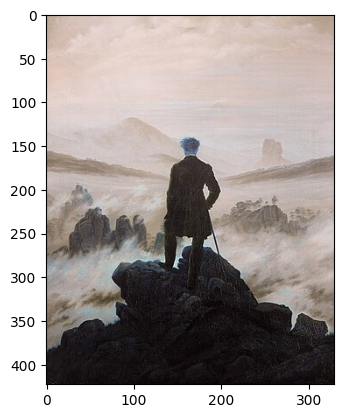

In [2]:
image_path = Path("../docs/testing_human.jpg")
image = cv2.imread(image_path)
plt.imshow(image)

Далее выберем модель для тестов. Я остановился на YOLO, так как она имеет наилучшую точность среди однопроходных детекторов. Для взаимодействия с моделями этого семейства есть фрейворк от Ultralyticks. Но для демонтсрации своих знаний выбрал Pytorch. (Так же в задании упоминалось, что нельзя все написать в 10 строчек...)

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /home/samurai/.cache/torch/hub/ultralytics_yolov5_master
/home/samurai/.cache/torch/hub/ultralytics_yolov5_master/utils/general.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
YOLOv5 🚀 2025-6-21 Python-3.10.12 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 1050, 2048MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Далее займемся предобработкой, обработкой и постобработкой данных.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# preprocessing
trans = v2.Compose([
    v2.ToTensor(),
    v2.Resize((448, 448)),
])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
inp = trans(image).unsqueeze(0).to(device)


# inference
model.eval().to(device)
with torch.no_grad():
    outputs_temp = model(inp)


# postprocessing
outputs_temp = outputs_temp.squeeze()

# select one class - person
clss = outputs_temp[::, 5:]
indxs = torch.argmax(clss, dim=1)
person = torch.where(indxs == 0)

# score filtering
outputs_temp = outputs_temp[person]
scores = outputs_temp[::, 4]
score_thresh = torch.where(scores >= 0.5)

outputs_temp = outputs_temp[score_thresh]

bboxes = outputs_temp[::, :4]
scores = outputs_temp[::, 4]
clss = outputs_temp[::, 5:]
indxs = torch.argmax(clss, dim=1)

# non-max suprations
indices = nms(bboxes, scores, iou_threshold=0.0)

bboxes = bboxes[indices.to(device)] / 448
scores = scores[indices.to(device)]
indxs = indxs[indices.to(device)]
outputs = zip(bboxes, scores, indxs)

/home/samurai/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:879: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Отрисуем полученные bboxes с помощью написанной функции show_results из модуля tools.py

In [5]:
new_img = show_results(image, outputs)


Сохраним полученное изображение. Не забудим перевести его в формат BGR, так как мы выполняли обратную операцию (bgr->rgb) ранее.

In [6]:
new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR)
cv2.imwrite("./new_human.jpg", new_img)

plt.imshow(new_img)
plt.show()

Оформим тот же код в виде пайплайна для нашей модели и запустим main.py уже для видео.

In [ ]:
!python3 main.py ../docs/crowd.mp4

Using cache found in /home/samurai/.cache/torch/hub/ultralytics_yolov5_master
/home/samurai/.cache/torch/hub/ultralytics_yolov5_master/utils/general.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
